# COVID-19 correlated variables on Mexican States and Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

In [5]:
admin2['CVE_MUNI'] = admin2['CVE_ENT'] + admin2['CVE_MUN']

In [6]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005


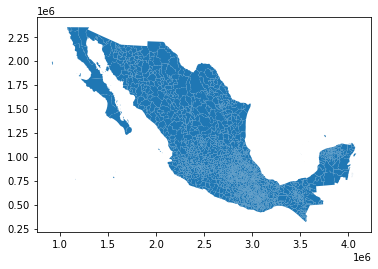

In [7]:
admin2.plot();

## Map of Variable data for Municipalities

Get COVID-19 data form week 3 analyzes file

In [8]:
population_admin2 = pd.read_csv('../data/week3analyzesMunicipalities.csv')

In [9]:
population_admin2.head()

,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,1001,2488.417083,192.832053,228.487791,4.262056,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,1002,933.862850,21.626298,72.743001,0.000000,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,1003,1688.610928,72.416063,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,1004,786.144934,23.643457,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,1005,643.704295,45.320469,47.624900,0.000000,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [10]:
population_admin2['CVE_MUNI'] = population_admin2['cve_ent'].apply(lambda i: f'{i:05d}')

In [11]:
population_admin2.head()

,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm,CVE_MUNI
0,1001,2488.417083,192.832053,228.487791,4.262056,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043,01001
1,1002,933.862850,21.626298,72.743001,0.000000,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672,01002
2,1003,1688.610928,72.416063,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308,01003
3,1004,786.144934,23.643457,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013,01004
4,1005,643.704295,45.320469,47.624900,0.000000,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641,01005


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [12]:
df_admin2 = admin2.merge(population_admin2, on='CVE_MUNI')

In [13]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001,1001,2488.417083,192.832053,228.487791,4.262056,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002,1002,933.862850,21.626298,72.743001,0.000000,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003,1003,1688.610928,72.416063,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004,1004,786.144934,23.643457,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005,1005,643.704295,45.320469,47.624900,0.000000,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Obtain the columns names with data

In [14]:
var = df_admin2.columns[7:-1]

To pick another variable to plot is neccesary to run the code only from the next cell

In [15]:
var_widget = widgets.Dropdown(options=var, description='Select variable:',value='case_rate')

After running the next cell is neccesary to pick the variable of interest and keep running the code

In [16]:
display(var_widget)

Dropdown(description='Select variable:', options=('case_rate', 'case_rate_last_60_days', 'death_rate', 'death_…

In [17]:
var_widget = var_widget.value

Plot variable data

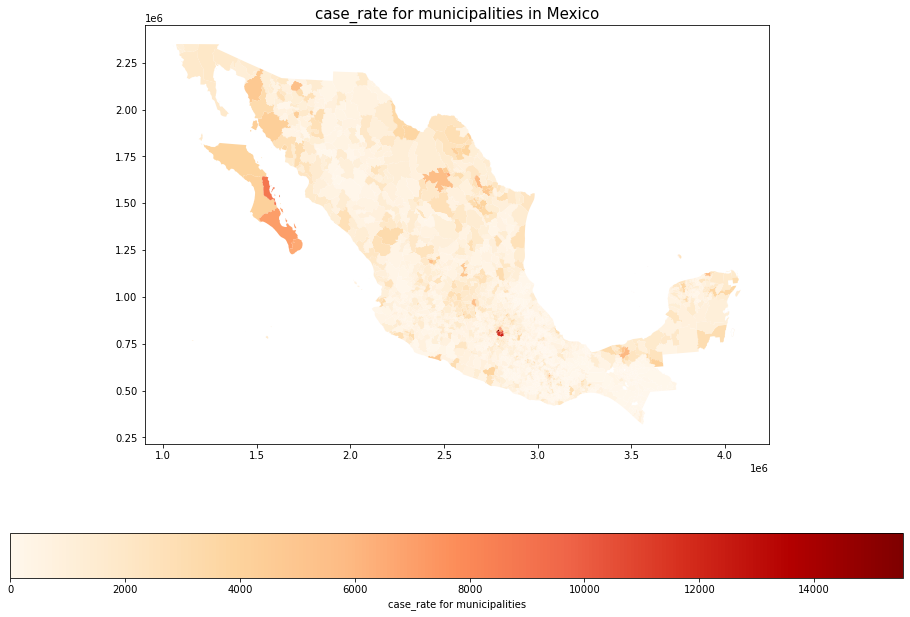

In [18]:
title = '{} for municipalities in Mexico'.format(var_widget)
ax1 = df_admin2.plot(column=var_widget, 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': '{} for municipalities'.format(var_widget), 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

## View Variable data for Municipalities in a selected State

Get info for states

In [19]:
admin1_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin1.parquet'

In [20]:
resp = urlopen(admin1_url)
admin1 = pd.read_parquet(BytesIO(resp.read()), columns=['CVE_ENT','NOMGEO'])

Get the list of states

In [21]:
states = admin1['NOMGEO'].unique()

Create a dropdown menu of the states.

In [22]:
state_widget = widgets.Dropdown(options=states, description='Select state:', value='Aguascalientes')

In [23]:
display(state_widget)

Dropdown(description='Select state:', options=('Aguascalientes', 'Baja California', 'Baja California Sur', 'Ca…

Get the selected state

In [24]:
state = state_widget.value

Filter dataframe by state code

In [25]:
state_code = admin1.query(f'NOMGEO == "{state}"')['CVE_ENT'].values[0]
df_state = df_admin2.query(f'CVE_ENT == "{state_code}"')

In [26]:
df_state.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,CVE_MUNI,cve_ent,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",01001,1001,2488.417083,192.832053,228.487791,4.262056,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",01002,1002,933.862850,21.626298,72.743001,0.000000,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",01003,1003,1688.610928,72.416063,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,01004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",01004,1004,786.144934,23.643457,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,01005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",01005,1005,643.704295,45.320469,47.624900,0.000000,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Plot the municipalities of the state selected with the variable selected

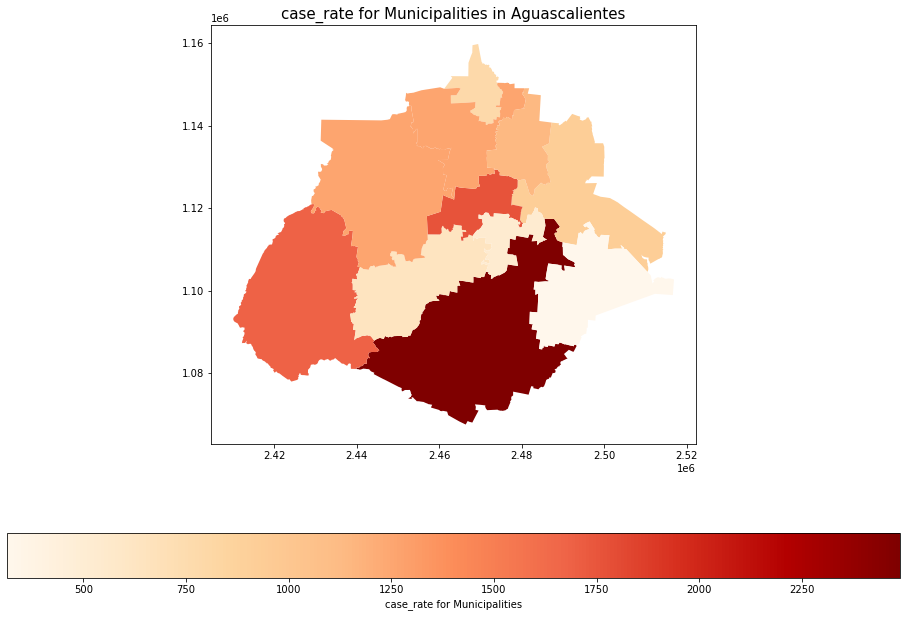

In [27]:
title = f'{var_widget} for Municipalities in {state}'
ax2 = df_state.plot(column=var_widget,
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': '{} for Municipalities'.format(var_widget), 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax2.set_title(title, fontsize=15);

This analyzes is useful in case of studying a single state of interest.